In [1]:
import pandas as pd

# read the csv file and define the columns
# The columns wil be: 
#   date: days in one year (in the format of: mm.dd.)  
#   17max: max temperature in the days of 2017
#   17min: min temperature in the days of 2017 
#   18max: max temperature in the days of 2018 ...
df = pd.read_csv('temp.csv', sep=';', header=None)
df.columns = ['date','17max','17min','18max','18min','19max','19min']
# convert the temperatures from string to float (from "-0,4" to "-0.4" and finally -0.4)
df['17max'] = df['17max'].str.replace(',','.').astype(float)
df['17min'] = df['17min'].str.replace(',','.').astype(float)
df['18max'] = df['18max'].str.replace(',','.').astype(float)
df['18min'] = df['18min'].str.replace(',','.').astype(float)
df['19max'] = df['19max'].str.replace(',','.').astype(float)
df['19min'] = df['19min'].str.replace(',','.').astype(float)

# print the head of the dataframe
# for example the maximum temperature was -0.5 °C in 2017.01.02., in 2019.01.03. the minimum temperature was -3.3 °C
df.head()

,date,17max,17min,18max,18min,19max,19min
0,1. 1.,-1.6,-6.0,6.4,1.3,2.7,-4.6
1,1. 2.,-0.5,-4.8,8.2,3.9,3.1,-0.7
2,1. 3.,4.2,-0.7,6.9,3.1,0.3,-3.3
3,1. 4.,4.3,-0.9,12.4,4.6,-1.0,-6.3
4,1. 5.,3.1,-4.2,10.5,5.3,2.2,-3.2


In [2]:
# I'll train my network to predict minimum and maximum temperature in a day, (the mean will be the mean of theese two)
# based on the temperatures a year before, and on the previous n days
# so for example:
#    if the current Y (that we want to predict) is 2018.05.06. max and min temperature, and the n is 2 
#    then the X is: 2017.05.06. , 2018.05.04., 2018.05.05. max and min temperature 
import numpy as np
np.random.seed(123)

# in 2019 we have only data till 10.10.
dataSizeIn2019 = df.iloc[:,5].dropna(axis=0).shape[0]

# previous n days, i choose it relatively big
##################### 
# it has a great effect on the training, 
# if it is small the network can reach low test and train loss, 
# but it wont be able to predict future temperatures
#####################
prevDays = dataSizeIn2019

# with this dataset we can train on the temperatures from 2018.01.01 to 2019.10.10.
Ymax = np.concatenate((df.iloc[:,3], df.iloc[:dataSizeIn2019,5]), axis=None)
Ymin = np.concatenate((df.iloc[:,4], df.iloc[:dataSizeIn2019,6]), axis=None)

# we add the last year temperatures to X
Xmax = np.concatenate((df.iloc[:,1], df.iloc[:dataSizeIn2019,3]), axis=None)
Xmin = np.concatenate((df.iloc[:,2], df.iloc[:dataSizeIn2019,4]), axis=None)

# we add the temperatures of the previous n day to X
for i in range(prevDays, 0, -1):
    maxDayBefore = np.concatenate((df.iloc[-i:,1], df.iloc[:,3], df.iloc[:dataSizeIn2019-i,5]), axis=None)
    minDayBefore = np.concatenate((df.iloc[-i:,2], df.iloc[:,4], df.iloc[:dataSizeIn2019-i,6]), axis=None)
    Xmax = np.vstack((Xmax, maxDayBefore))
    Xmin = np.vstack((Xmin, minDayBefore))

# we stack the min and max together
X = np.vstack((Xmax, Xmin)).T
Y = np.vstack((Ymax, Ymin)).T

# so we have 648 data tuples
print(X.shape)
print(Y.shape)

(648, 568)
(648, 2)


In [3]:
from sklearn.preprocessing import StandardScaler

# shuffle the data 
# without shuffling we will validate and test on only one or two months data, hence the temperatures will be close to each other
indices = np.random.permutation(X.shape[0])
Xshuf, Yshuf = X[indices], Y[indices]

# separate the train, validation and test data
valid_split=0.2
test_split=0.1
X_train = Xshuf[0:int(Xshuf.shape[0]*(1-valid_split-test_split))]
Y_train = Yshuf[0:int(Xshuf.shape[0]*(1-valid_split-test_split))]
X_valid = Xshuf[int(Xshuf.shape[0]*(1-valid_split-test_split)):int(Xshuf.shape[0]*(1-test_split))]
Y_valid = Yshuf[int(Xshuf.shape[0]*(1-valid_split-test_split)):int(Xshuf.shape[0]*(1-test_split))]
X_test  = Xshuf[int(Xshuf.shape[0]*(1-test_split)):]
Y_test  = Yshuf[int(Xshuf.shape[0]*(1-test_split)):]

# standardize them
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

# see if the datasets have mean close to 0 and deviance close to 1
# if we shuffle the data, the means an deviances will be close to each other
print("TRAIN mean es std:",np.mean(X_train), np.std(X_train))
print("VALID mean es std:",np.mean(X_valid), np.std(X_valid))
print("TEST mean es std:",np.mean(X_test), np.std(X_test))

TRAIN mean es std: -2.2843055336129825e-16 1.0
VALID mean es std: -0.02518027449468362 1.0028278139368312
TEST mean es std: -0.003751922932698914 1.0035494102426454


In [13]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# the early stopping, and the best model saver callback
es = EarlyStopping(patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='model_boston.hdf5', save_best_only=True, verbose=1)

# Sequential keras model with linear activation on the output, becouse we have to predict temperatures
# it has dropout in the input layer to prevent overfitting
model = Sequential()
 
model.add(Dense(256, input_dim = Xshuf.shape[1], activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2))

# the model will use Adam optimizer with 0.01 learning rate, and mean squared error loss function
adam = Adam(lr=0.01)
model.compile(loss='mse', optimizer=adam)

In [5]:
# train the network on training data, validate on validation data
# we use early stopping, hence the big epoch size (it will stop when needed)
# The dataset is relatively small, so I've chosen 8 as batch size
model.fit(X_train, Y_train,
          validation_data=(X_valid,Y_valid),
          epochs=1000000000,
          batch_size=8,
          callbacks=[mcp,es])

Instructions for updating:
Use tf.cast instead.
Train on 453 samples, validate on 130 samples
Epoch 1/1000000000
453/453 [==============================] - 4s 9ms/step - loss: 124.2633 - val_loss: 56.2544

Epoch 00001: val_loss improved from inf to 56.25440, saving model to model_boston.hdf5
Epoch 2/1000000000
453/453 [==============================] - 0s 892us/step - loss: 27.5019 - val_loss: 27.4169

Epoch 00002: val_loss improved from 56.25440 to 27.41694, saving model to model_boston.hdf5
Epoch 3/1000000000
453/453 [==============================] - 0s 917us/step - loss: 22.1683 - val_loss: 25.3834

Epoch 00003: val_loss improved from 27.41694 to 25.38337, saving model to model_boston.hdf5
Epoch 4/1000000000
453/453 [==============================] - 0s 935us/step - loss: 17.4516 - val_loss: 23.1190

Epoch 00004: val_loss improved from 25.38337 to 23.11900, saving model to model_boston.hdf5
Epoch 5/1000000000
453/453 [==============================] - 0s 904us/step - loss: 19.7214 

453/453 [==============================] - 0s 880us/step - loss: 13.5731 - val_loss: 17.2549

Epoch 00045: val_loss did not improve from 15.24961
Epoch 46/1000000000
453/453 [==============================] - 0s 933us/step - loss: 14.2002 - val_loss: 16.8360

Epoch 00046: val_loss did not improve from 15.24961
Epoch 47/1000000000
453/453 [==============================] - 0s 886us/step - loss: 13.2683 - val_loss: 16.1614

Epoch 00047: val_loss did not improve from 15.24961
Epoch 00047: early stopping


In [6]:
# load the best model, and print it's error with the test data
# so if the MSE is about 9, then the model predictions differ 3 °C on average from the original temperature
model = load_model('model_boston.hdf5')
test_err = model.evaluate(X_test, Y_test)
print("test MSE: ",test_err)

65/65 [==============================] - 0s 1ms/step
test MSE:  10.79776216653677


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot the actual and the predicted minimum temperatures in the test dataset
plt.figure(figsize=(10,10))
minPreds = model.predict(X_test)[:,1]
sns.regplot(Y_test[:,1], minPreds.reshape(-1)).set(xlim=(-10,25), ylim=(-10,25))
# ant plot the maximum
plt.figure(figsize=(10,10))
maxPreds = model.predict(X_test)[:,0]
sns.regplot(Y_test[:,0], maxPreds.reshape(-1)).set(xlim=(-8,35), ylim=(-8,35))


[(-8, 35), (-8, 35)]

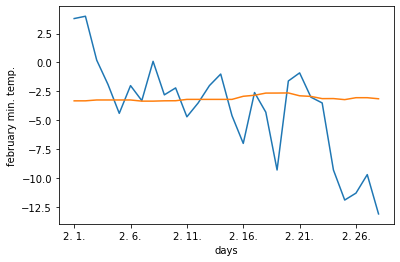

In [8]:
# for example 2018 february:
#   blue line is the actual minimum temperature
#   orange one is the predicted

#####################
# if we choose n (the days before) to be small (for example 3) , the shape of the predicted data would be similar to the actual
# if we choose it big, then it will be close to the mean
#####################

febrPreds = model.predict(X)[31:59,1]
febr = Y[31:59,1]

plt.plot(range(1,29),febr)
plt.plot(range(1,29),febrPreds)
plt.ylabel('february min. temp.')
plt.xticks(range(1,29,5),df.iloc[range(31,59,5),0])
plt.xlabel('days')
plt.show()

In [9]:
# get the inputs to predict the temperature in the given day in 2019
def getX(day):
    # get the maximum and minumum temperature at the given day in 2018
    Xmax = df.iloc[day,3]
    Xmin = df.iloc[day,4]

    # we add the temperatures of the previous n day in 2019 to X
    for i in range(prevDays, 0, -1):
        maxDayBefore = df.iloc[day-i,5]
        minDayBefore = df.iloc[day-i,6]
        Xmax = np.vstack((Xmax, maxDayBefore))
        Xmin = np.vstack((Xmin, minDayBefore))       

    # we stack the min and max together
    X = np.vstack((Xmax, Xmin)).T
    
    return X

In [10]:
# itarete through the remaining days of 2019:
#    predict each temperature, and store them in the dataframe, so we can predict the next one

for d in range(dataSizeIn2019, 365):
    x = getX(d)
    preds = model.predict(x)
    df.iloc[d,5] = preds[0,0]
    df.iloc[d,6] = preds[0,1]      

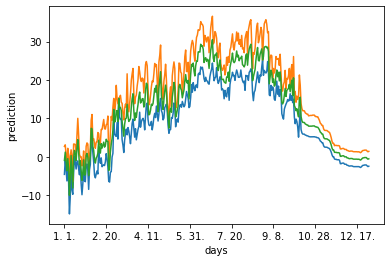

In [11]:
# plot the temperatures in 2019 (from 10.10. the predicted ones)
# orange=max, blue=mean, green=average
#####################
# if we choose n big, then it can predict the future temperatures quite well, otherwise it can't
#####################
maxT = df.iloc[0:365,5]
minT = df.iloc[0:365,6]
avg = (maxT+minT)/2
plt.plot(range(0,365),minT)
plt.plot(range(0,365),maxT)
plt.plot(range(0,365),avg)
plt.ylabel('prediction')
plt.xticks(range(0,365,50),df.iloc[range(0,365,50),0])
plt.xlabel('days')
plt.show()

In [12]:
#october 30. = 302
#november 1. = 304
#november 22. = 325

#print the predicted temperatures at the given days
def printTemp(d,ma,mi,a):
    print('Predicted temperatures in '+ d +': Max: '+ str(ma) +', Min: '+ str(mi) +', Avg: '+ str(a))
    
printTemp("october 30.", df.iloc[302,5], df.iloc[302,6], (df.iloc[302,5]+df.iloc[302,6])/2) 
printTemp('movember 1.', df.iloc[304,5], df.iloc[304,6], (df.iloc[304,5]+df.iloc[304,6])/2)
printTemp('november 22.', df.iloc[325,5], df.iloc[325,6], (df.iloc[325,5]+df.iloc[325,6])/2)

Predicted temperatures in october 30.: Max: 10.393692016601562, Min: 4.967970371246338, Avg: 7.68083119392395
Predicted temperatures in movember 1.: Max: 9.888849258422852, Min: 4.854878902435303, Avg: 7.371864080429077
Predicted temperatures in november 22.: Max: 2.957486867904663, Min: -0.678295373916626, Avg: 1.1395957469940186
